# Import Package

In [2]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("conda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

# Dataset & Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [66]:
bs = 128
crop_size = 64 # kita harus pake crop size karena gambar yang kita miliki memiliki ukuran yang berbeda2 sehingga harus diseragamkan

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([   # data test jangan di augmentasi
    transforms.Resize(70),   # resize untuk menyamakan resolusi dari gambar yang berbeda-beda, tapi tetep lebih besar dari crop_size
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])


train_set = datasets.ImageFolder("data/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)


test_set = datasets.ImageFolder("data/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [67]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [23]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Architecture & Config

In [14]:
from jcopdl.layers import conv_block, linear_block

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),  # (input channel, output channel, ), ini dengan menggunakan block
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 10, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [16]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [17]:
model = CNN().to(device)
criterion = nn.NLLLoss() 
optimizer = optim.AdamW(model.parameters(), lr=0.001) # Optimizer AdamW sudaha ada Regulerization sehingga bisa mengurangi Overfit
callback = Callback(model, config, outdir="model")  # callback membantu kita save model

# Training

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost /len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.8901 | Test_cost  = 0.5439 | Train_score = 0.6619 | Test_score = 0.7908 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5805 | Test_cost  = 0.4764 | Train_score = 0.7782 | Test_score = 0.8206 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5170 | Test_cost  = 0.4333 | Train_score = 0.8052 | Test_score = 0.8337 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4691 | Test_cost  = 0.4201 | Train_score = 0.8216 | Test_score = 0.8409 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4323 | Test_cost  = 0.3597 | Train_score = 0.8354 | Test_score = 0.8649 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4081 | Test_cost  = 0.3628 | Train_score = 0.8451 | Test_score = 0.8620 |
==> EarlyStop patience =  1 | Best test_score: 0.8649


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3989 | Test_cost  = 0.3600 | Train_score = 0.8505 | Test_score = 0.8685 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3806 | Test_cost  = 0.3313 | Train_score = 0.8558 | Test_score = 0.8774 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3710 | Test_cost  = 0.3395 | Train_score = 0.8606 | Test_score = 0.8719 |
==> EarlyStop patience =  1 | Best test_score: 0.8774


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3614 | Test_cost  = 0.3304 | Train_score = 0.8639 | Test_score = 0.8782 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3519 | Test_cost  = 0.3076 | Train_score = 0.8681 | Test_score = 0.8873 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3463 | Test_cost  = 0.3076 | Train_score = 0.8688 | Test_score = 0.8835 |
==> EarlyStop patience =  1 | Best test_score: 0.8873


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3411 | Test_cost  = 0.3247 | Train_score = 0.8726 | Test_score = 0.8780 |
==> EarlyStop patience =  2 | Best test_score: 0.8873


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3273 | Test_cost  = 0.3098 | Train_score = 0.8779 | Test_score = 0.8816 |
==> EarlyStop patience =  3 | Best test_score: 0.8873


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3301 | Test_cost  = 0.2989 | Train_score = 0.8759 | Test_score = 0.8881 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3169 | Test_cost  = 0.2902 | Train_score = 0.8810 | Test_score = 0.8931 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3122 | Test_cost  = 0.2859 | Train_score = 0.8831 | Test_score = 0.8942 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3065 | Test_cost  = 0.2900 | Train_score = 0.8868 | Test_score = 0.8952 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3049 | Test_cost  = 0.2937 | Train_score = 0.8859 | Test_score = 0.8880 |
==> EarlyStop patience =  1 | Best test_score: 0.8952


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3005 | Test_cost  = 0.2790 | Train_score = 0.8872 | Test_score = 0.8981 |


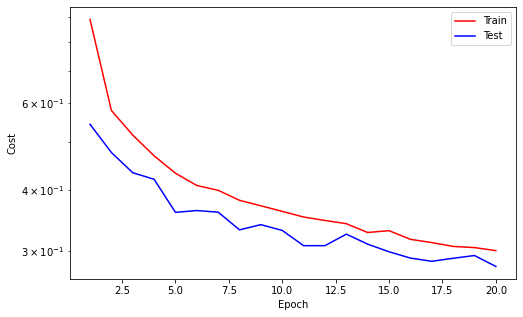

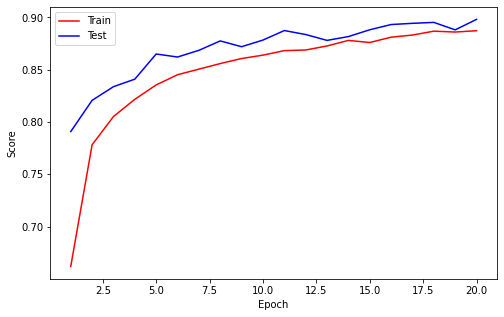

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2928 | Test_cost  = 0.2772 | Train_score = 0.8904 | Test_score = 0.8983 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2920 | Test_cost  = 0.2853 | Train_score = 0.8907 | Test_score = 0.8948 |
==> EarlyStop patience =  1 | Best test_score: 0.8983


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2911 | Test_cost  = 0.2861 | Train_score = 0.8905 | Test_score = 0.8924 |
==> EarlyStop patience =  2 | Best test_score: 0.8983


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2875 | Test_cost  = 0.2702 | Train_score = 0.8902 | Test_score = 0.9004 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2842 | Test_cost  = 0.2652 | Train_score = 0.8924 | Test_score = 0.9064 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2794 | Test_cost  = 0.2684 | Train_score = 0.8947 | Test_score = 0.9022 |
==> EarlyStop patience =  1 | Best test_score: 0.9064


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2776 | Test_cost  = 0.2620 | Train_score = 0.8972 | Test_score = 0.9038 |
==> EarlyStop patience =  2 | Best test_score: 0.9064


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2722 | Test_cost  = 0.2742 | Train_score = 0.8969 | Test_score = 0.8985 |
==> EarlyStop patience =  3 | Best test_score: 0.9064


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2703 | Test_cost  = 0.2612 | Train_score = 0.8979 | Test_score = 0.9033 |
==> EarlyStop patience =  4 | Best test_score: 0.9064


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2717 | Test_cost  = 0.2640 | Train_score = 0.8996 | Test_score = 0.9030 |
==> EarlyStop patience =  5 | Best test_score: 0.9064
==> Execute Early Stopping at epoch: 30 | Best test_score: 0.9064
==> Best model is saved at model


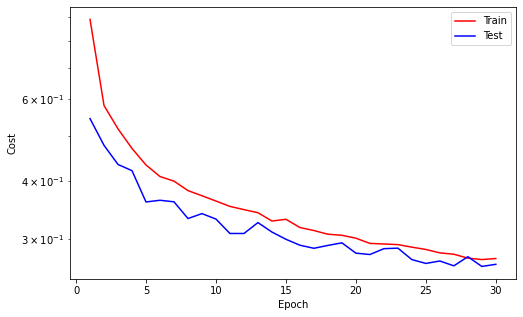

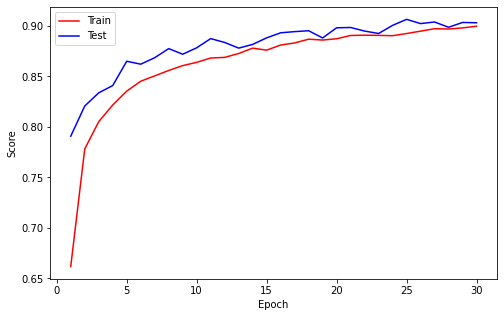

In [14]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint(ini cocok untuk training yang berat yang berminggu2 atau yang takut mati lampu ditengah jalan, jadi kalo bisa tiap berapa epoch ada save checkpoint) untuk safety
    callback.save_checkpoint()
    
    # sambil training sambil ngeplot
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict with data from datatest

In [68]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [71]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
# preds

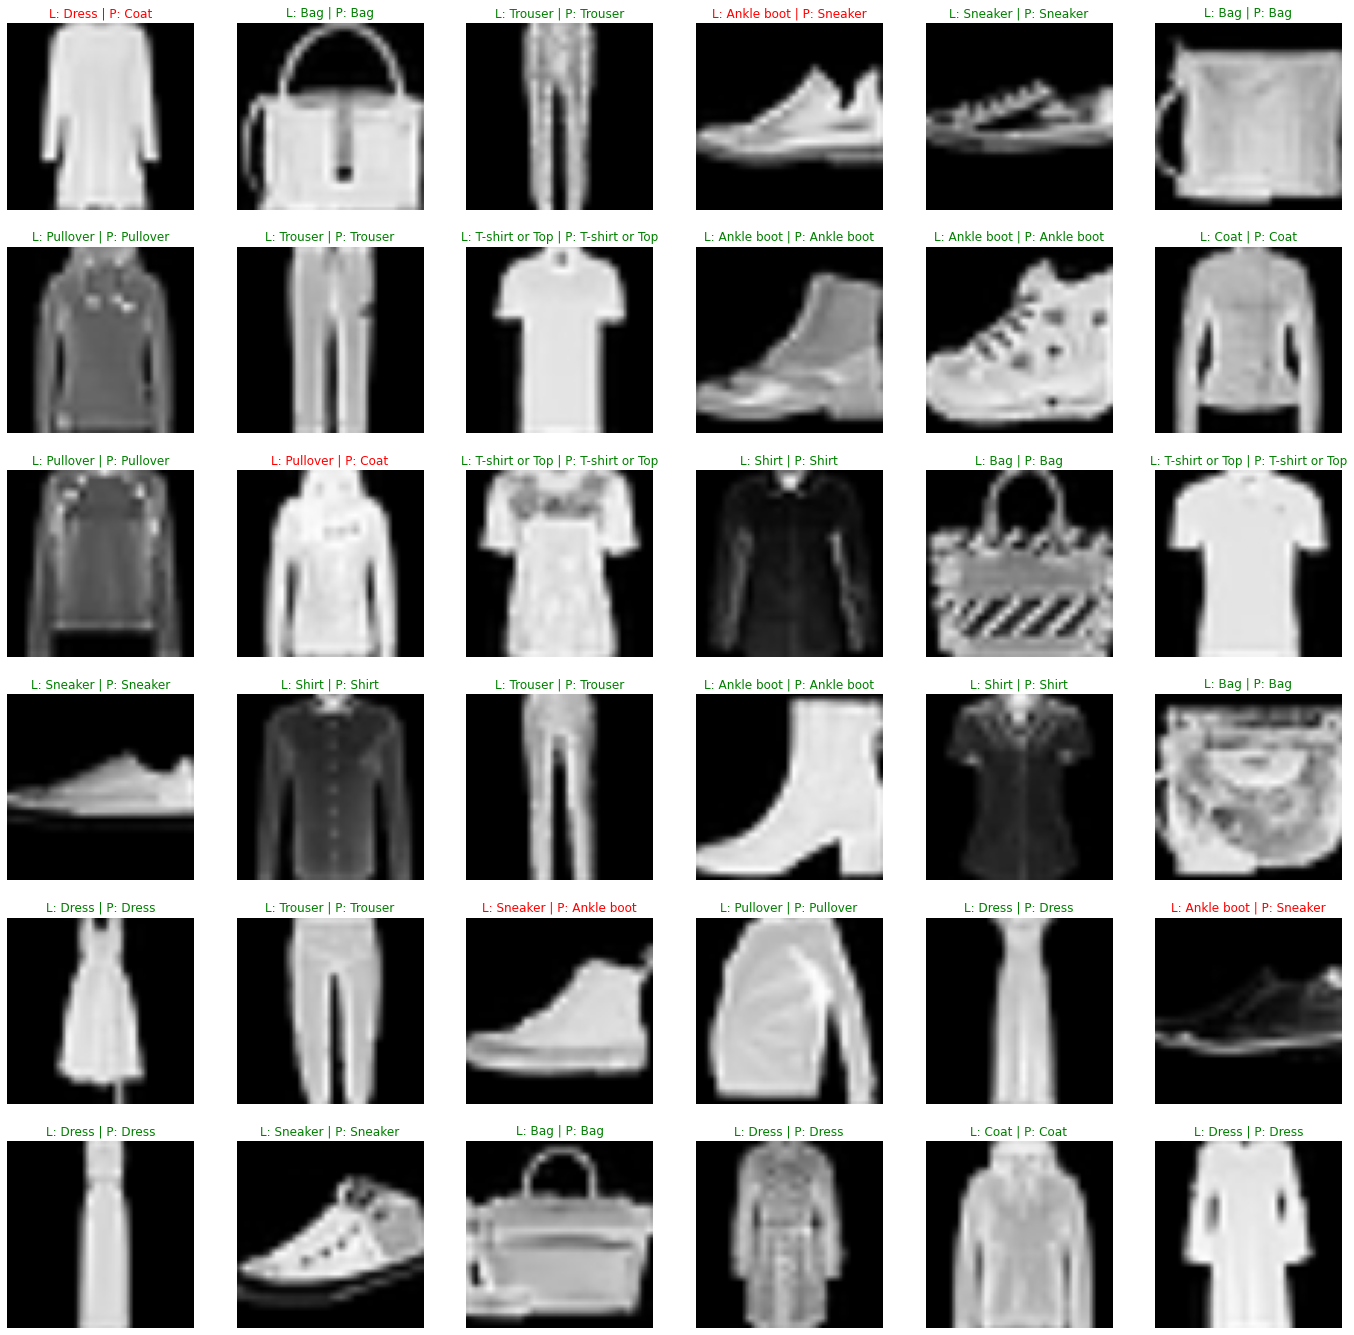

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

### From the picture above:

### The red color means the prediction does not match the original<br>
### The green color means it matches the original.

# Predict with a image from the internet

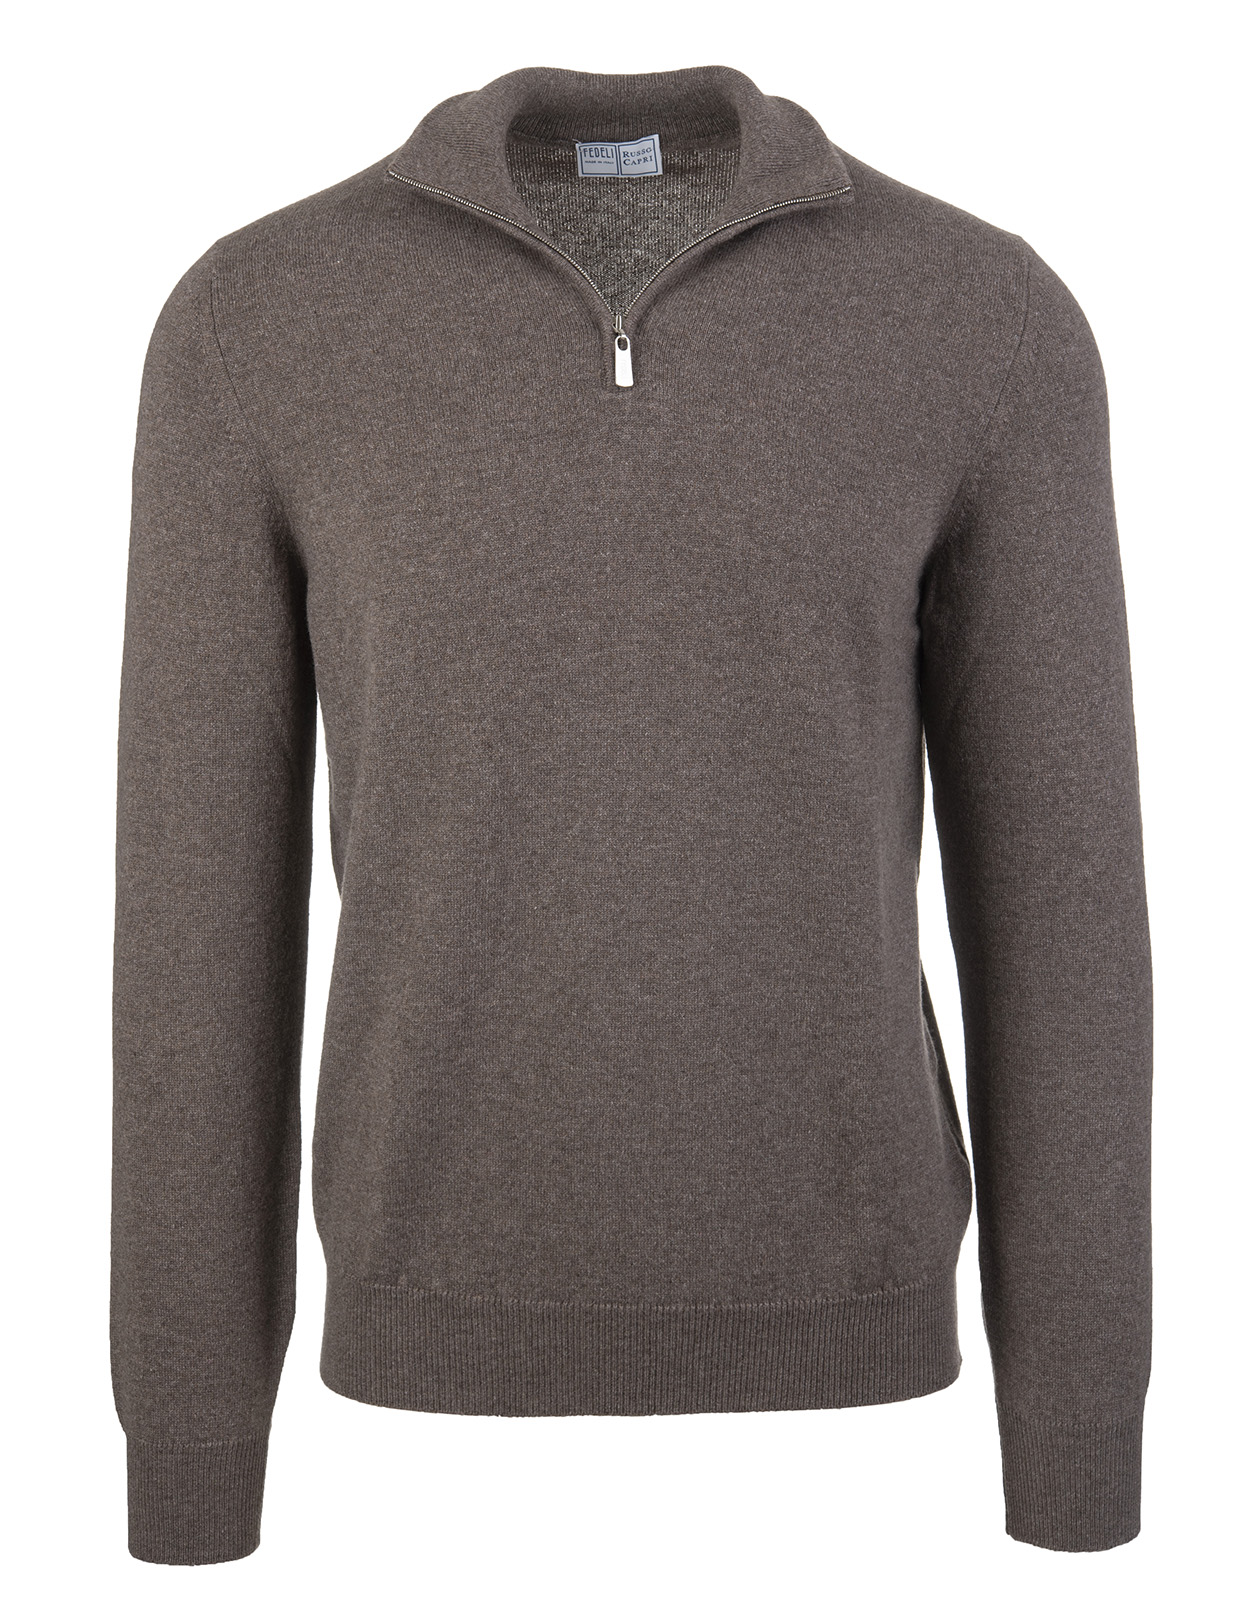

In [75]:
from IPython.display import Image
Image(filename='pull.jpg', width=500)

### The picture above is a Pullover, we will predict whether the model can see the picture above is a Pullover? Let's predict.

#### Load  the best model

In [18]:
weights = torch.load('model/weights_best.pth', map_location='cpu')
config = torch.load('model/configs.pth', map_location='cpu')

model = CNN().to(device)
model.load_state_dict(weights)
model = model.to(device)

In [19]:
model

CNN(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_

#### Predict

In [80]:
bs = 128
crop_size = 64 # kita harus pake crop size karena gambar yang kita miliki memiliki ukuran yang berbeda2 sehingga harus diseragamkan


test_transform = transforms.Compose([   # data test jangan di augmentasi
    transforms.Resize(70),   # resize untuk menyamakan resolusi dari gambar yang berbeda-beda, tapi tetep lebih besar dari crop_size
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])





test_set1 = datasets.ImageFolder("data/data_1/cek/", transform=test_transform)
testloader = DataLoader(test_set1, batch_size=bs, shuffle=True)

In [81]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [82]:
feature.shape

torch.Size([1, 3, 64, 64])

tensor([4])
['Pullover']


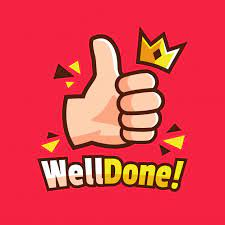

In [84]:
with torch.no_grad():  # dihasilkan akurasi dengan weigths yang telah ditimpa dengan weights yang berasal dari Save Weights
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
print(preds)
print([label2cat[pred] for pred in preds])

from IPython.display import Image
Image(filename='thumsup.jpg', width=200)

#### Prediction turned out to be correct that the image is a "Pullover"